In [1]:
!pip install torchsummary

In [2]:
!pip install adabound torchmetrics

In [3]:
!nvidia-smi

Tue Feb 11 19:39:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from adabound import AdaBound
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from PIL import Image, ImageDraw, ImageFont

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
from torchvision import models
from scipy.ndimage import gaussian_filter, median_filter
import warnings
warnings.filterwarnings('ignore')

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize


In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
import os
import numpy as np
import nibabel as nib
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from matplotlib import pyplot as plt
from skimage.util import montage
from skimage.transform import rotate

In [8]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

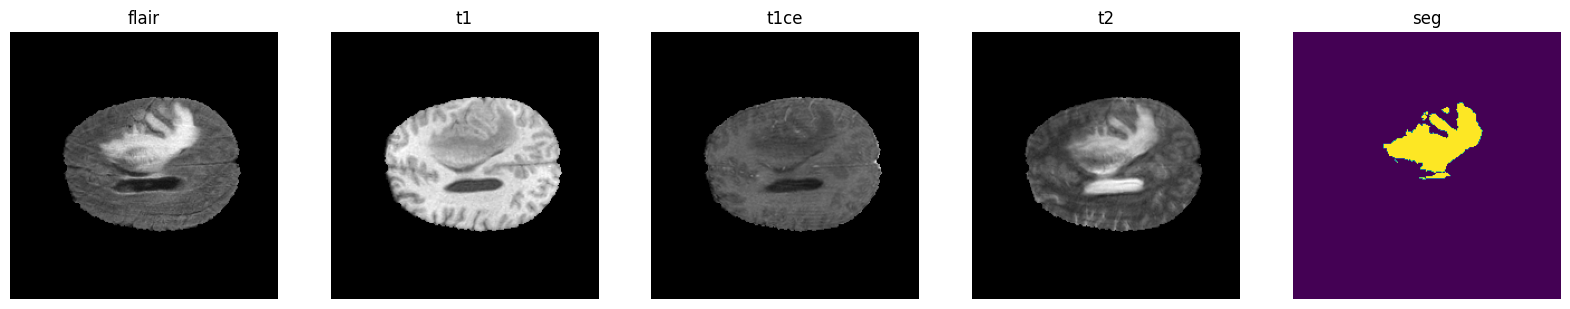

In [9]:
# Define a function to load and return image data
def load_image_data(dataset_path, image_types):
    images = {}
    for image_type in image_types:
        images[image_type] = nib.load(f"{dataset_path}/BraTS20_Training_001_{image_type}.nii").get_fdata()
    return images

# Define a function to plot images
def plot_images(images, slice_idx):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        axs[i].imshow(image[:, :, slice_idx], cmap='gray' if 'seg' not in name else None)
        axs[i].set_title(name)
        axs[i].axis('off')
    plt.show()

# Define types of images
image_types = ['flair', 't1', 't1ce', 't2', 'seg']  # list of image types

# Load images and plot
images = load_image_data(TRAIN_DATASET_PATH + 'BraTS20_Training_001', image_types)
slice_idx = images['flair'].shape[0] // 2 - 25  # Adjust the slice index as needed
plot_images(images, slice_idx)


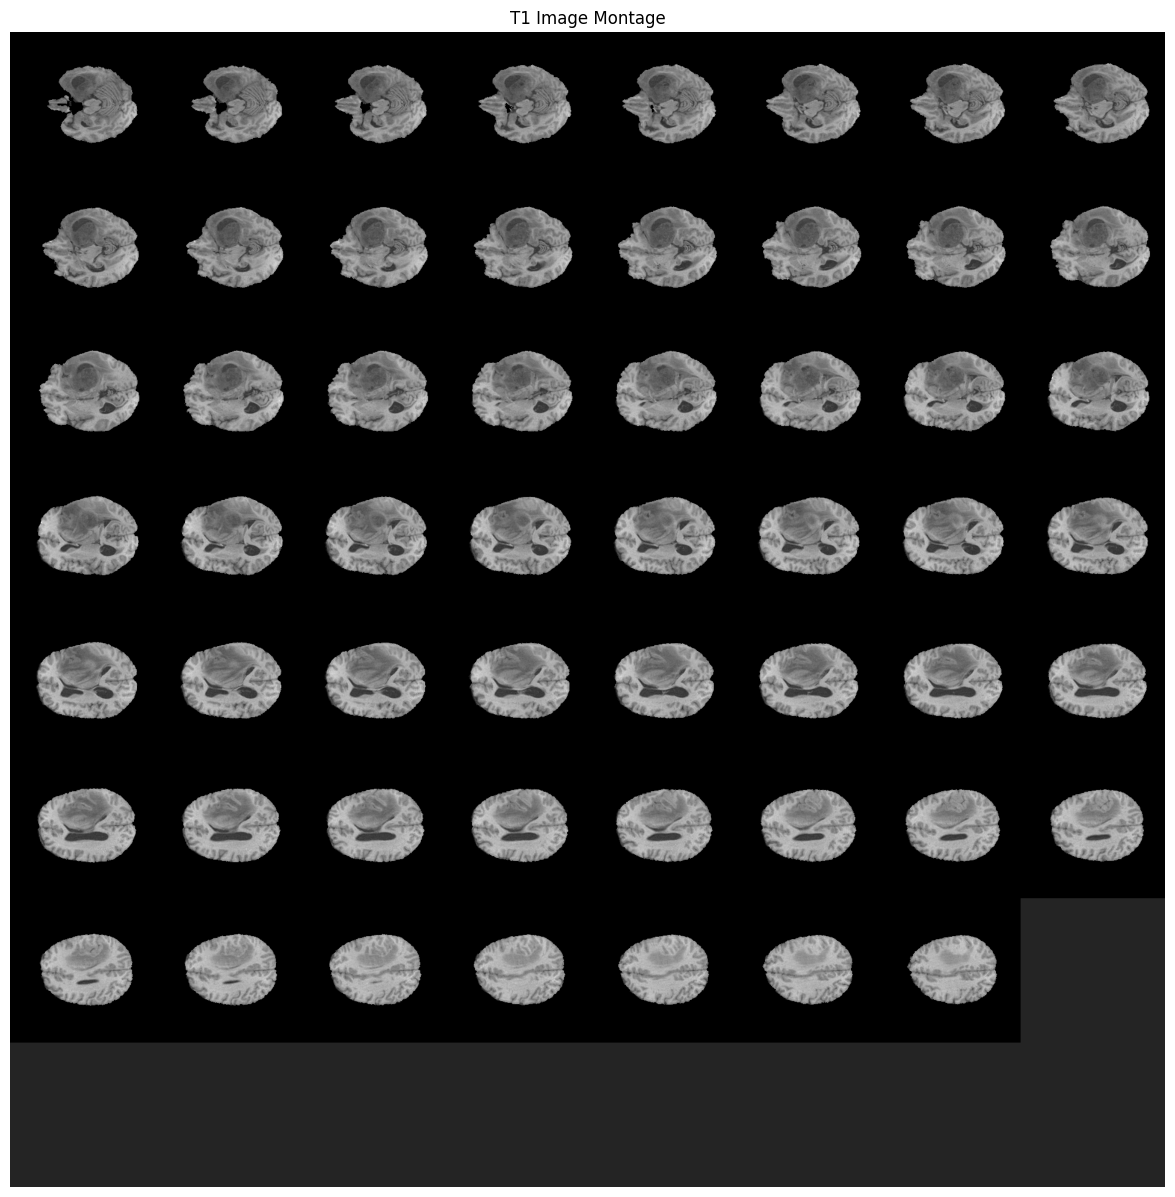

In [10]:
# Define a function to load and montage an image with specified slice skipping
def load_and_montage_image(file_path, skip_slices=(50, -50)):
    # Load the image data
    image = nib.load(file_path).get_fdata()
    # Transpose and slice, then create a montage for visualization
    image_slices = image[..., skip_slices[0]:skip_slices[1]]
    return montage(np.transpose(image_slices, (2, 0, 1)))

# Path to the T1 image
file_path = TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii'

# Load and create montage
montage_image = load_and_montage_image(file_path)

# Plot the montage
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(montage_image, cmap='gray')
ax.set_title('T1 Image Montage')
ax.axis('off')
plt.show()


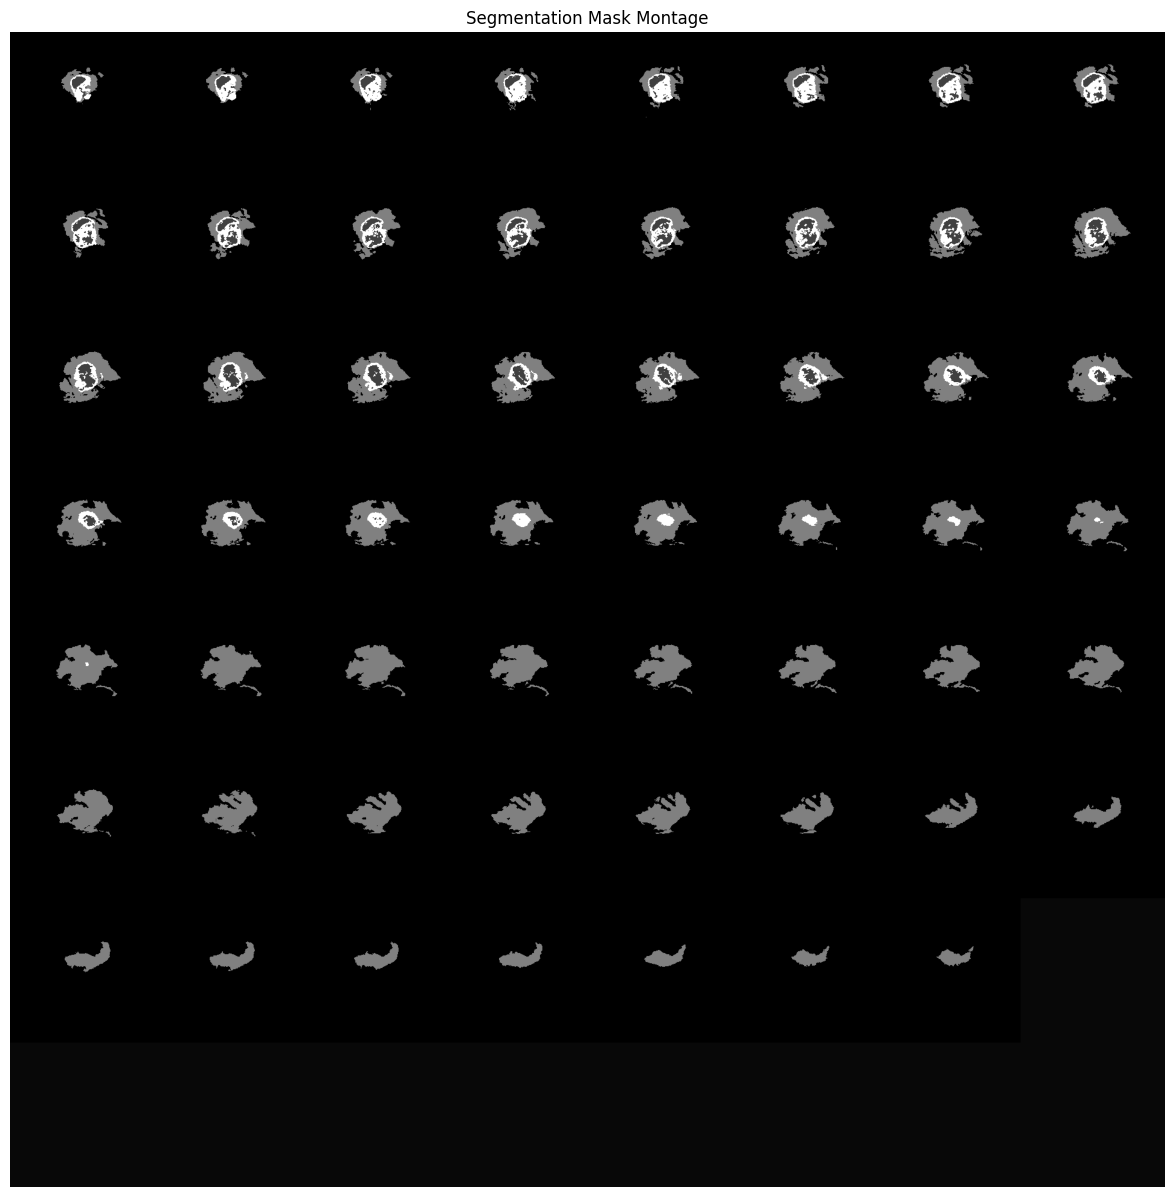

In [11]:
# Path to the mask file
mask_file_path = TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii'

# Load and create montage for the mask
montage_mask = load_and_montage_image(mask_file_path)

# Plot the mask montage
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(montage_mask, cmap='gray')
ax.set_title('Segmentation Mask Montage')
ax.axis('off')
plt.show()

# Model Architecture

In [12]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [13]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [14]:
class ImprovedConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ImprovedConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout2d(0.1)
        self.se = SEBlock(out_ch)
        
        # Residual connection if channels don't match
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        
        out += residual
        out = self.relu(out)
        return out

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)  # Ensures it is not a trainable parameter

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


In [16]:
class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.enc1 = ImprovedConvBlock(1, 64)
        self.enc2 = ImprovedConvBlock(64, 128)
        self.enc3 = ImprovedConvBlock(128, 256)
        self.enc4 = ImprovedConvBlock(256, 512)
        self.enc5 = ImprovedConvBlock(512, 1024)

        # Transformer block
        encoder_layer = TransformerEncoderLayer(
            d_model=1024,
            nhead=8,
            dim_feedforward=2048,
            dropout=0.1,
            activation='gelu',
            norm_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=2)
        self.pos_encoding = PositionalEncoding(1024)

        # Decoder
        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = ImprovedConvBlock(1024, 512)
        
        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = ImprovedConvBlock(512, 256)
        
        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = ImprovedConvBlock(256, 128)
        
        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = ImprovedConvBlock(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.max_pool(e1))
        e3 = self.enc3(self.max_pool(e2))
        e4 = self.enc4(self.max_pool(e3))
        e5 = self.enc5(self.max_pool(e4))

        # Transformer
        b, c, h, w = e5.shape
        transformer_input = e5.flatten(2).permute(2, 0, 1)
        transformer_input = self.pos_encoding(transformer_input)
        transformer_output = self.transformer(transformer_input)
        transformer_output = transformer_output.permute(1, 2, 0).view(b, c, h, w)

        # Decoder with skip connections
        d1 = self.up_conv1(transformer_output)
        d1 = torch.cat([e4, d1], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up_conv2(d1)
        d2 = torch.cat([e3, d2], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up_conv3(d2)
        d3 = torch.cat([e2, d3], dim=1)
        d3 = self.dec3(d3)

        d4 = self.up_conv4(d3)
        d4 = torch.cat([e1, d4], dim=1)
        d4 = self.dec4(d4)

        output = self.final_conv(d4)
        return output

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(num_classes=1).to(device)

In [18]:
# Create input tensor and move it to the same device
input_tensor_A = torch.randn(1, 1, 240, 240).to(device)
model(input_tensor_A)

tensor([[[[ 2.6975, 12.0425,  2.3334,  ..., 10.8275,  5.8921,  8.8498],
          [ 8.1695, -3.1394,  6.8536,  ...,  0.7751,  8.6883,  4.4871],
          [-0.2890, -4.5216,  3.6959,  ..., -5.1694,  1.0447,  8.0176],
          ...,
          [16.7981, -4.5200, 11.2595,  ...,  3.8122,  8.9735,  1.7514],
          [ 5.3981,  0.3046,  2.6297,  ...,  4.9362, 10.2040,  5.1573],
          [ 5.0362,  2.2934,  7.1132,  ..., -5.4114, 13.5611,  3.2018]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [19]:
from torchinfo import summary

model = UNet(num_classes=1)
summary(model, input_size=(1, 1, 240, 240))


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 240, 240]          --
├─ImprovedConvBlock: 1-1                      [1, 64, 240, 240]         --
│    └─Conv2d: 2-1                            [1, 64, 240, 240]         128
│    └─Conv2d: 2-2                            [1, 64, 240, 240]         640
│    └─BatchNorm2d: 2-3                       [1, 64, 240, 240]         128
│    └─LeakyReLU: 2-4                         [1, 64, 240, 240]         --
│    └─Dropout2d: 2-5                         [1, 64, 240, 240]         --
│    └─Conv2d: 2-6                            [1, 64, 240, 240]         36,928
│    └─BatchNorm2d: 2-7                       [1, 64, 240, 240]         128
│    └─SEBlock: 2-8                           [1, 64, 240, 240]         --
│    │    └─AdaptiveAvgPool2d: 3-1            [1, 64, 1, 1]             --
│    │    └─Sequential: 3-2                   [1, 64]                   512
│    └─Leak

In [20]:
from sklearn.model_selection import train_test_split
import os

# Get train directories, excluding the ill-formatted name
train_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir() and f.name != 'BraTS20_Training_355']
train_ides = [os.path.basename(directory) for directory in train_directories]

# Split the dataset into train (250) and validation+test (118)
train_ids, val_test_ids = train_test_split(train_ides, train_size=250, test_size=118, random_state=42)

# Further split validation+test into valid (73) and test (45)
val_ids, test_ids = train_test_split(val_test_ids, train_size=73, test_size=45, random_state=42)

# Print the counts of each set
print(f"Train: {len(train_ids)} | Validation: {len(val_ids)} | Test: {len(test_ids)}")


Train: 250 | Validation: 73 | Test: 45


In [21]:
# Set random seed
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

155


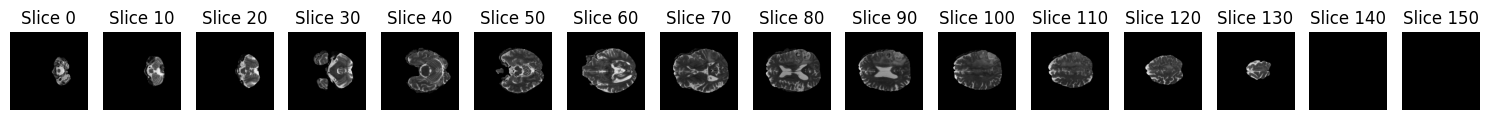

In [22]:
import matplotlib.pyplot as plt
import nibabel as nib
import os

def show_every_10th_slice(volume_path, start=0, step=10):
    """
    Display every 10th slice from a given 3D volume.
    
    Args:
        volume_path (str): Path to the NIfTI file.
        start (int): Starting slice index (default: 0).
        step (int): Step size (default: 10, for every 10th slice).
    """
    # Load the volume
    volume = nib.load(volume_path).get_fdata()
    
    # Get the total number of slices
    num_slices = volume.shape[2]
    print(num_slices)
    
    # Determine slices to display
    slice_indices = range(start, num_slices, step)
    
    # Create a plot for the slices
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, len(slice_indices), i + 1)
        plt.imshow(volume[:, :, idx], cmap="gray")
        plt.title(f"Slice {idx}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage
# Provide the path to your NIfTI file (e.g., T2-weighted volume)
example_volume_path = os.path.join(TRAIN_DATASET_PATH, train_ids[8], f"{train_ids[8]}_t2.nii")

# Show every 10th slice starting from slice 0
show_every_10th_slice(example_volume_path, start=0, step=10)


In [23]:
import os
import numpy as np
import nibabel as nib
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2


import numpy as np

class NiftiDataset(Dataset):
    def __init__(self, ids, path, transform=None, num_slices=10, slice_range=(70, 100)):
        self.ids = ids
        self.path = path
        self.transform = transform
        self.num_slices = num_slices  # Number of slices to sample
        self.slice_range = slice_range  # Valid range for slice selection
        
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # CLAHE instance

        # Define augmentation pipeline
        self.augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ElasticTransform(p=0.1, alpha=1, sigma=50),
        ])
        
        # Precompute slice indices
        self.selected_slices = np.linspace(slice_range[0], slice_range[1], num_slices, dtype=int)

    def __len__(self):
        return len(self.ids) * self.num_slices  # 15 slices per volume

    def __getitem__(self, idx):
        volume_idx = idx // self.num_slices  # Determine volume index
        slice_idx = self.selected_slices[idx % self.num_slices]  # Evenly spaced slice selection
    
        # Load the T2 image and segmentation for the current slice
        id = self.ids[volume_idx]
        t2_path = os.path.join(self.path, id, f"{id}_t2.nii")
        seg_path = os.path.join(self.path, id, f"{id}_seg.nii")
        
        t2 = nib.load(t2_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()
    
        image = t2[:, :, slice_idx] / t2.max()  # Normalize to [0, 1]
        mask = (seg[:, :, slice_idx] > 0).astype(np.uint8)  # Convert mask to uint8
    
        # Apply CLAHE for contrast enhancement
        image_clahe = self.clahe.apply((image * 255).astype(np.uint8)) / 255.0
    
        # Combine image and mask for simultaneous augmentation
        augmented = self.augmentations(image=image_clahe, mask=mask)
        augmented_image = augmented["image"]
        augmented_mask = augmented["mask"]

        # Convert to torch tensors and add channel dimension
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32).unsqueeze(0)
        augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32).unsqueeze(0)
        
        return augmented_image, augmented_mask


# Create Dataset and DataLoader
batch_size = 16
#slice_range = (100, 110)

train_dataset = NiftiDataset(train_ids, TRAIN_DATASET_PATH)
val_dataset = NiftiDataset(val_ids, TRAIN_DATASET_PATH)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [24]:
print(len(train_dataloader),len(val_dataloader))
print(len(train_dataset),len(val_dataset))

157 46
2500 730


Image batch shape: torch.Size([16, 1, 240, 240]), Mask batch shape: torch.Size([16, 1, 240, 240])


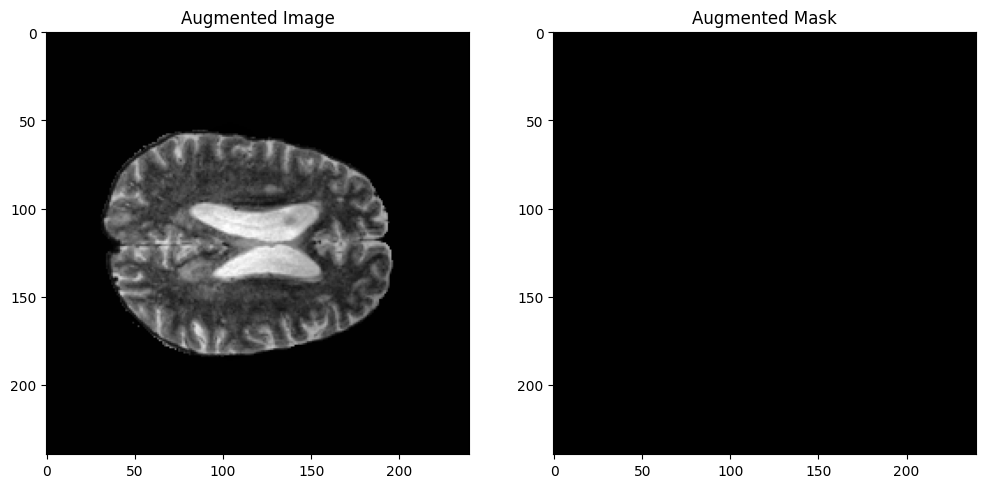

In [25]:
# Get a single batch of images and masks
images, masks = next(iter(train_dataloader))

# Move to CPU and detach tensors for visualization
images, masks = images.cpu().detach(), masks.cpu().detach()

# Check shapes
print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")

# Plot the first image and mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Augmented Image")
plt.imshow(images[0, 0], cmap='gray')  # First image in the batch
plt.subplot(1, 2, 2)
plt.title("Augmented Mask")
plt.imshow(masks[0, 0], cmap='gray')  # First mask in the batch
plt.show()


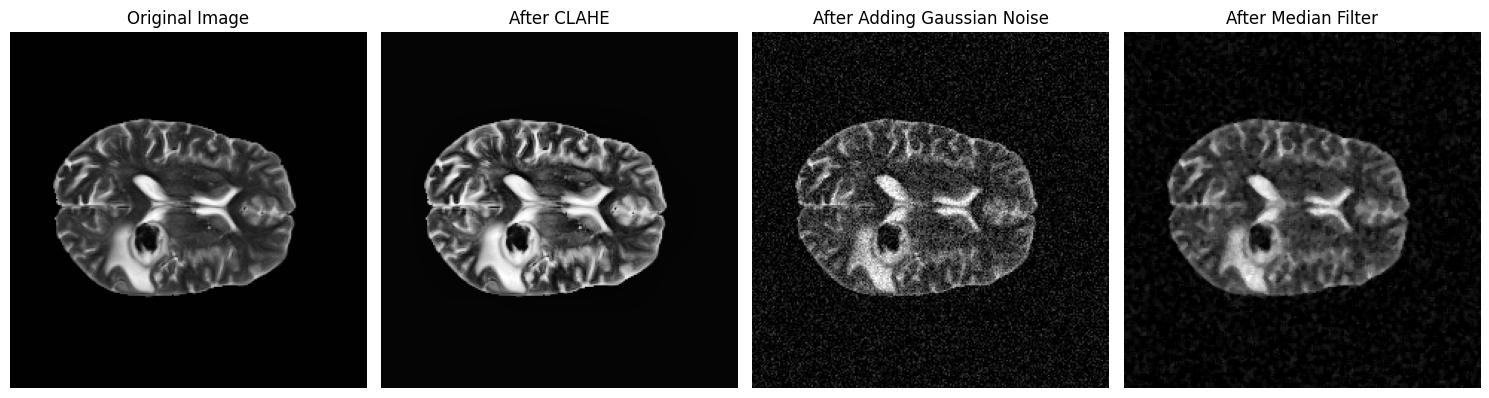

In [26]:
# Get one batch of data (just the first image)
train_dataset = NiftiDataset(train_ids, TRAIN_DATASET_PATH)
train_dataloader_example = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Load a single image and its mask from the DataLoader
image, mask = next(iter(train_dataloader_example))

# Convert to numpy (taking the first image from the batch)
image = image[0, 0].numpy()

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_clahe = clahe.apply((image * 255).astype(np.uint8)) / 255.0

# Add Gaussian noise
mean = 0
stddev = 0.1  # Standard deviation for Gaussian noise
noise = np.random.normal(mean, stddev, image.shape)
image_noise = image + noise
image_noise = np.clip(image_noise, 0, 1)  # Clip to ensure values are within [0, 1]

# Apply Median filter
image_median_filter = median_filter(image_noise, size=3)

# Plot the images
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

# Original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

# Image after CLAHE
ax[1].imshow(image_clahe, cmap='gray')
ax[1].set_title("After CLAHE")
ax[1].axis('off')

# Image after adding Gaussian noise
ax[2].imshow(image_noise, cmap='gray')
ax[2].set_title("After Adding Gaussian Noise")
ax[2].axis('off')

# Image after applying Median filter
ax[3].imshow(image_median_filter, cmap='gray')
ax[3].set_title("After Median Filter")
ax[3].axis('off')

plt.tight_layout()
plt.show()

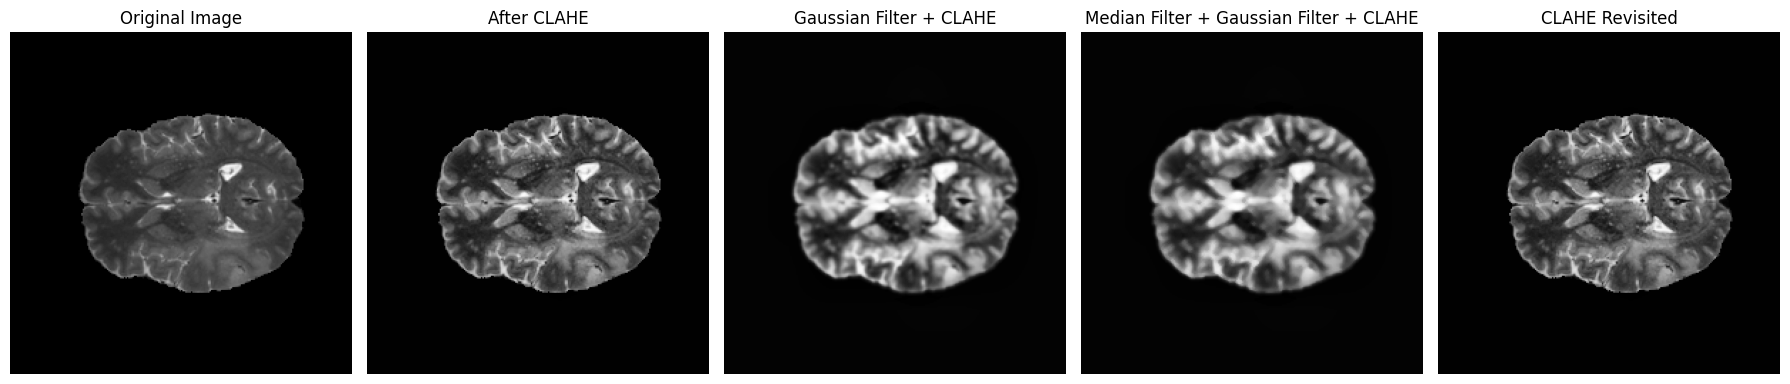

In [27]:
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter

# Path to the specific volume and modality (T2)
volume_id = 'BraTS20_Training_003'  # Patient ID for this example
dataset_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Load the T2 image for this volume
t2_path = os.path.join(dataset_path, volume_id, f"{volume_id}_t2.nii")
t2_image = nib.load(t2_path).get_fdata()

# Take the middle slice for visualization (you can adjust as needed)
slice_idx = t2_image.shape[2] // 2
image = t2_image[:, :, slice_idx]

# Normalize to [0, 1] for consistency
image = image / image.max()

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_clahe = clahe.apply((image * 255).astype(np.uint8)) / 255.0

# Apply Gaussian filter followed by CLAHE
image_gaussian = gaussian_filter(image_clahe, sigma=1)
image_gaussian_clahe = clahe.apply((image_gaussian * 255).astype(np.uint8)) / 255.0

# Apply Median filter followed by Gaussian filter and CLAHE
image_median = median_filter(image_gaussian, size=3)  # Apply median filter
image_median_gaussian_clahe = clahe.apply((image_median * 255).astype(np.uint8)) / 255.0

# Plotting the images
fig, ax = plt.subplots(1, 5, figsize=(18, 5))

# Original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

# Image after CLAHE
ax[1].imshow(image_clahe, cmap='gray')
ax[1].set_title("After CLAHE")
ax[1].axis('off')

# Image after Gaussian filter + CLAHE
ax[2].imshow(image_gaussian_clahe, cmap='gray')
ax[2].set_title("Gaussian Filter + CLAHE")
ax[2].axis('off')

# Image after Median filter + Gaussian filter + CLAHE
ax[3].imshow(image_median_gaussian_clahe, cmap='gray')
ax[3].set_title("Median Filter + Gaussian Filter + CLAHE")
ax[3].axis('off')

# Show image after CLAHE (again to demonstrate the effect)
ax[4].imshow(image_clahe, cmap='gray')
ax[4].set_title("CLAHE Revisited")
ax[4].axis('off')

plt.tight_layout()
plt.show()


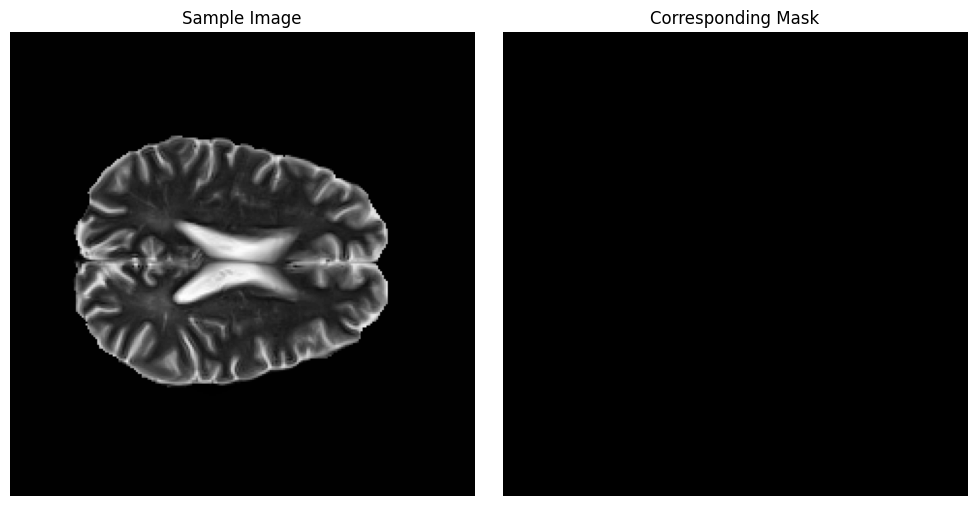

In [28]:
import matplotlib.pyplot as plt

# Get a batch of images and masks from the dataloader
X, Y = next(iter(train_dataloader))

# Create a figure with subplots
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(X[0, 0], cmap='gray')
plt.title('Sample Image')
plt.axis('off')  # Hide axis ticks and labels

# Plot the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(Y[0, 0], cmap='gray')
plt.title('Corresponding Mask')
plt.axis('off')  # Hide axis ticks and labels

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from sklearn.metrics import f1_score, balanced_accuracy_score
from torchmetrics import JaccardIndex, Accuracy, Specificity, Recall
from tqdm.auto import tqdm

def Dice(pred: torch.Tensor, mask: torch.Tensor):
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum()
    if union == 0:  # Handle the case where both pred and mask are empty
        return 1.0  # Perfect match for empty masks
    dice = (2 * intersection) / union
    return dice.cpu().numpy()

In [30]:
class VAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=128, input_size=240):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        # Calculate flattened size
        with torch.no_grad():
            test_input = torch.zeros(1, input_channels, input_size, input_size)
            test_output = self.encoder(test_input)
            self.flattened_size = test_output.view(1, -1).size(1)

        # Latent space
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_log_var = nn.Linear(self.flattened_size, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.2),
            
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.2),
            
            nn.ConvTranspose2d(32, input_channels, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        self.kl_weight = 0.0
        self.kl_weight_max = 1.0
        self.kl_weight_step = 0.01

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        spatial_size = int(math.sqrt(self.flattened_size // 128))
        x = x.view(x.size(0), 128, spatial_size, spatial_size)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [31]:
class MultiFusionAttention(nn.Module):
    def __init__(self, input_dim):
        super(MultiFusionAttention, self).__init__()
        self.norm1 = nn.LayerNorm([input_dim, 30, 30])  # Adjust size as needed
        self.norm2 = nn.LayerNorm([input_dim, 30, 30])
        
        self.query_proj = nn.Conv2d(input_dim, input_dim, 1)
        self.key_proj = nn.Conv2d(input_dim, input_dim, 1)
        self.value_proj = nn.Conv2d(input_dim, input_dim, 1)
        
        self.scale = input_dim ** 0.5
        
        self.residual = nn.Sequential(
            nn.Conv2d(input_dim, input_dim, 1),
            nn.BatchNorm2d(input_dim)
        )

    def forward(self, z, x):
        residual = self.residual(z)
        
        z = self.norm1(z)
        x = self.norm2(x)
        
        query = self.query_proj(z).flatten(2).transpose(-1, -2)
        key = self.key_proj(x).flatten(2)
        value = self.value_proj(x).flatten(2).transpose(-1, -2)
        
        attention = F.softmax(torch.matmul(query, key) / self.scale, dim=-1)
        out = torch.matmul(attention, value).transpose(-1, -2).view_as(z)
        
        return out + residual

In [32]:
class DiffusionCorrectionModel(nn.Module):
    def __init__(self, unet, vae, attention, T=10):
        super(DiffusionCorrectionModel, self).__init__()
        self.unet = unet
        self.vae = vae
        self.attention = attention
        self.T = T
        
        # Improved noise schedule
        self.beta = self.cosine_beta_schedule(T)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
        self.max_grad_norm = 1.0

    def cosine_beta_schedule(self, timesteps):
        steps = torch.linspace(0, timesteps, timesteps + 1)
        x = steps / timesteps
        alphas_cumprod = torch.cos((x + 0.008) / 1.008 * math.pi * 0.5) ** 2
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def forward_diffusion(self, z0, t):
        noise = torch.randn_like(z0)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        zt = torch.sqrt(alpha_bar_t) * z0 + torch.sqrt(1 - alpha_bar_t) * noise
        return zt, noise

    def reverse_diffusion(self, zT, conditional_x):
        for t in reversed(range(self.T)):
            alpha_t = self.alpha[t].view(-1, 1, 1, 1)
            beta_t = self.beta[t].view(-1, 1, 1, 1)
            gradient = self.attention(zT, conditional_x)
            zT = (zT - beta_t * gradient) / torch.sqrt(alpha_t)
        return zT

    def forward(self, x, ground_truth=None):
        # Initial segmentation
        initial_mask = self.unet(x)
        
        if self.training and ground_truth is not None:
            # Calculate error map
            error_map = torch.abs(initial_mask - ground_truth)
            
            # VAE processing
            latent, mu, log_var = self.vae(error_map)
            
            # Diffusion process
            zT, _ = self.forward_diffusion(latent, self.T - 1)
            z0_reconstructed = self.reverse_diffusion(zT, x)
            
            # Final correction
            corrected_error_map = self.vae.decode(z0_reconstructed)
            corrected_mask = initial_mask - corrected_error_map
            
            return corrected_mask, mu, log_var
        
        return initial_mask, None, None

In [33]:
def compute_sensitivity(preds, targets):
    TP = ((preds == 1) & (targets == 1)).sum().item()
    FN = ((preds == 0) & (targets == 1)).sum().item()
    return TP / (TP + FN) if (TP + FN) > 0 else 0.0

In [34]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import torch
from torchmetrics import JaccardIndex, Accuracy, Recall, Specificity
from skimage.metrics import hausdorff_distance
from sklearn.metrics import f1_score, balanced_accuracy_score
import glob

def save_checkpoint(model, optimizer, epoch, save_dir="checkpoints", max_ckpts=3):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")



def train_model_CD(
    train_dataloader, val_dataloader, model, num_epochs, optimizer, 
    criterion_unet, criterion_diffusion, device, save_path="metrics_history.json",
    final_model_path="final_model.pth"
):
    # Check if metrics_history file exists and load it
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            metrics_history = json.load(f)
    else:
        metrics_history = defaultdict(list)

    required_keys = [
        "train_loss", "train_dice", "train_f1", "train_bal_acc", 
        "train_iou", "train_accuracy", "train_recall", "train_specificity", "train_sensitivity","train_hausdorff",
        "val_loss", "val_dice", "val_f1", "val_bal_acc", 
        "val_iou", "val_accuracy", "val_recall", "val_specificity", "val_sensitivity" , "val_hausdorff"
    ]
    
    for key in required_keys:
        if key not in metrics_history:
            metrics_history[key] = []

    start_epoch = len(metrics_history["train_loss"])
    print(f"Resuming training from epoch {start_epoch}/{num_epochs}")

    train_iou_metric = JaccardIndex(task='binary').to(device)
    train_accuracy_metric = Accuracy(task='binary').to(device)
    train_recall_metric = Recall(task='binary').to(device)
    train_specificity_metric = Specificity(task='binary').to(device)

    val_iou_metric = JaccardIndex(task='binary').to(device)
    val_accuracy_metric = Accuracy(task='binary').to(device)
    val_recall_metric = Recall(task='binary').to(device)
    val_specificity_metric = Specificity(task='binary').to(device)
    

    try:
        for epoch in range(len(metrics_history["train_loss"]), num_epochs):
            model.train()
            train_loss, train_dice_score = 0.0, 0.0
            train_f1_scores, train_bal_accs, train_sensitivities, train_hausdorffs = [], [], [], []

            train_iou_metric.reset()
            train_accuracy_metric.reset()
            train_recall_metric.reset()
            train_specificity_metric.reset()

            for inputs, ground_truth in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
                inputs, ground_truth = inputs.to(device), ground_truth.to(device)
                optimizer.zero_grad()

                initial_mask = model.unet(inputs)
                loss_unet = criterion_unet(initial_mask, ground_truth)
                error_map = torch.abs(initial_mask - ground_truth)
                reconstructed_error_map, mu, log_var = model.vae(error_map)
                loss_diffusion = criterion_diffusion(reconstructed_error_map, error_map)

                combined_loss = loss_unet + 0.5 * loss_diffusion
                combined_loss.backward()
                optimizer.step()

                train_loss += combined_loss.item()
                preds = (torch.sigmoid(initial_mask) >= 0.5).int()
                train_iou_metric.update(preds, ground_truth.int())
                train_accuracy_metric.update(preds, ground_truth.int())
                train_recall_metric.update(preds, ground_truth.int())
                train_specificity_metric.update(preds, ground_truth.int())
                if preds.sum() == 0 or ground_truth.sum() == 0:
                    train_hausdorffs.append(0)  # Assign 0 if one of them is empty
                else:
                    train_hausdorffs.append(hausdorff_distance(preds.cpu().numpy().astype(bool), ground_truth.cpu().numpy().astype(bool)))

                #print(hausdorff_distance(preds.cpu().numpy().astype(bool), ground_truth.cpu().numpy().astype(bool)))
                

                train_dice_score += Dice(preds, ground_truth)
                train_f1_scores.append(f1_score(ground_truth.cpu().numpy().flatten(), preds.cpu().numpy().flatten()))
                train_bal_accs.append(balanced_accuracy_score(ground_truth.cpu().numpy().flatten(), preds.cpu().numpy().flatten()))
                train_sensitivities.append(compute_sensitivity(preds, ground_truth))
                

            train_loss /= len(train_dataloader)
            train_dice_score /= len(train_dataloader)
            metrics_history["train_loss"].append(train_loss)
            metrics_history["train_dice"].append(train_dice_score)
            metrics_history["train_f1"].append(sum(train_f1_scores) / len(train_f1_scores))
            metrics_history["train_bal_acc"].append(sum(train_bal_accs) / len(train_bal_accs))
            metrics_history["train_iou"].append(train_iou_metric.compute().item())
            metrics_history["train_accuracy"].append(train_accuracy_metric.compute().item())
            metrics_history["train_recall"].append(train_recall_metric.compute().item())
            metrics_history["train_specificity"].append(train_specificity_metric.compute().item())
            metrics_history["train_sensitivity"].append(sum(train_sensitivities) / len(train_sensitivities))
            metrics_history["train_hausdorff"].append(sum(train_hausdorffs) / len(train_hausdorffs))

            model.eval()
            val_loss, val_dice_score = 0.0, 0.0
            val_f1_scores, val_bal_accs, val_sensitivities, val_hausdorffs = [], [], [], []

            val_iou_metric.reset()
            val_accuracy_metric.reset()
            val_recall_metric.reset()
            val_specificity_metric.reset()

            with torch.no_grad():
                for val_inputs, val_ground_truth in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                    val_inputs, val_ground_truth = val_inputs.to(device), val_ground_truth.to(device)
                    val_initial_mask = model.unet(val_inputs)
                    val_loss_unet = criterion_unet(val_initial_mask, val_ground_truth)
                    val_error_map = torch.abs(val_initial_mask - val_ground_truth)
                    val_reconstructed_error_map, val_mu, val_log_var  = model.vae(val_error_map)
                    val_loss_diffusion = criterion_diffusion(val_reconstructed_error_map, val_error_map)
                    val_combined_loss = val_loss_unet + 0.5 * val_loss_diffusion
                    val_loss += val_combined_loss.item()
                    
                    val_preds = (torch.sigmoid(val_initial_mask) >= 0.5).int()
                    val_iou_metric.update(val_preds, val_ground_truth.int())
                    val_accuracy_metric.update(val_preds, val_ground_truth.int())
                    val_recall_metric.update(val_preds, val_ground_truth.int())
                    val_specificity_metric.update(val_preds, val_ground_truth.int())
                    
                    if val_preds.sum() == 0 or val_ground_truth.sum() == 0:
                        val_hausdorffs.append(0)
                    else:
                        val_hausdorffs.append(hausdorff_distance(val_preds.cpu().numpy().astype(bool), val_ground_truth.cpu().numpy().astype(bool)))

                    #print(hausdorff_distance(val_preds.cpu().numpy().astype(bool), val_ground_truth.cpu().numpy().astype(bool)))

                    val_dice_score += Dice(preds, ground_truth)
                    val_f1_scores.append(f1_score(val_ground_truth.cpu().numpy().flatten(), val_preds.cpu().numpy().flatten()))
                    val_bal_accs.append(balanced_accuracy_score(val_ground_truth.cpu().numpy().flatten(), val_preds.cpu().numpy().flatten()))
                    val_sensitivities.append(compute_sensitivity(val_preds, val_ground_truth))
                    
            val_loss /= len(val_dataloader)
            val_dice_score /= len(val_dataloader)
            metrics_history["val_loss"].append(val_loss)
            metrics_history["val_dice"].append(val_dice_score)
            metrics_history["val_f1"].append(sum(val_f1_scores) / len(val_f1_scores))
            metrics_history["val_bal_acc"].append(sum(val_bal_accs) / len(val_bal_accs))
            metrics_history["val_iou"].append(val_iou_metric.compute().item())
            metrics_history["val_accuracy"].append(val_accuracy_metric.compute().item())
            metrics_history["val_recall"].append(val_recall_metric.compute().item())
            metrics_history["val_specificity"].append(val_specificity_metric.compute().item())
            metrics_history["val_sensitivity"].append(sum(val_sensitivities) / len(val_sensitivities))
            metrics_history["val_hausdorff"].append(sum(val_hausdorffs) / len(val_hausdorffs))

            with open(save_path, "w") as f:
                json.dump(metrics_history, f)

            save_checkpoint(model, optimizer, epoch)

            # Logging
            print(f"\nEpoch {epoch+1}/{num_epochs}:")
            print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice_score:.4f}, Train F1: {sum(train_f1_scores) / len(train_f1_scores):.4f}")
            print(f"Train IoU: {train_iou_metric.compute().item():.4f}, Train Accuracy: {train_accuracy_metric.compute().item():.4f}")
            print(f"Train Recall: {train_recall_metric.compute().item():.4f}, Train Specificity: {train_specificity_metric.compute().item():.4f}")
            print(f"Train Sensitivity: {metrics_history['train_sensitivity'][-1]:.4f}, Val Sensitivity: {metrics_history['val_sensitivity'][-1]:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice_score:.4f}, Val F1: {sum(val_f1_scores) / len(val_f1_scores):.4f}")
            print(f"Val IoU: {val_iou_metric.compute().item():.4f}, Val Accuracy: {val_accuracy_metric.compute().item():.4f}")
            print(f"Val Recall: {val_recall_metric.compute().item():.4f}, Val Specificity: {val_specificity_metric.compute().item():.4f}")
            print(f"Train hausdroff: {metrics_history['train_hausdorff'][-1]:.4f}, Val hausdroff: {metrics_history['val_hausdorff'][-1]:.4f}")

        torch.save(model.state_dict(), final_model_path)
        print(f"Final model weights saved at {final_model_path}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving progress...")
        with open(save_path, "w") as f:
            json.dump(metrics_history, f)
        save_checkpoint(model, optimizer, epoch)
        print("Progress saved.")

    return metrics_history


In [35]:
# Instantiate the model components
unet = UNet(num_classes=1).to(device)
vae = VAE(input_channels=1, latent_dim=128, input_size=240).to(device)  # Replace VQEncoder and VQDecoder
attention = MultiFusionAttention(input_dim=64).to(device)  # Multi-Fusion Attention

# Define the full model
model = DiffusionCorrectionModel(unet, vae, attention, T=8).to(device)

# Define loss functions and optimizer
criterion_unet = nn.BCEWithLogitsLoss()
#criterion_unet = nn.BCEWithLogitsLoss()
#criterion_unet = HybridLoss(dice_weight=0.6, bce_weight=0.4)
criterion_diffusion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)
#optimizer = AdaBound(model.parameters(),lr=1e-4,weight_decay=1e-5)

# Train the model
metrics_history = train_model_CD(
    train_dataloader,
    val_dataloader,
    model,
    num_epochs=80,
    optimizer=optimizer,
    criterion_unet=criterion_unet,
    criterion_diffusion=criterion_diffusion,
    device=device
)


Resuming training from epoch 0/80


Epoch 1/80 - Validation: 100%|██████████| 46/46 [04:03<00:00,  5.30s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 1/80:
Train Loss: 2.1593, Train Dice: 0.1052, Train F1: 0.1052
Train IoU: 0.0503, Train Accuracy: 0.7272
Train Recall: 0.4939, Train Specificity: 0.7342
Train Sensitivity: 0.4965, Val Sensitivity: 0.4669
Val Loss: 0.5865, Val Dice: 0.0325, Val F1: 0.2028
Val IoU: 0.1244, Val Accuracy: 0.9139
Val Recall: 0.5037, Val Specificity: 0.9241
Train hausdroff: 108.7227, Val hausdroff: 105.8896


Epoch 2/80 - Validation: 100%|██████████| 46/46 [03:31<00:00,  4.60s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 2/80:
Train Loss: 0.6613, Train Dice: 0.2084, Train F1: 0.2084
Train IoU: 0.1139, Train Accuracy: 0.8909
Train Recall: 0.4796, Train Specificity: 0.9033
Train Sensitivity: 0.4774, Val Sensitivity: 0.4634
Val Loss: 0.5078, Val Dice: 0.2726, Val F1: 0.2991
Val IoU: 0.2046, Val Accuracy: 0.9508
Val Recall: 0.5216, Val Specificity: 0.9615
Train hausdroff: 106.7480, Val hausdroff: 102.2230


Epoch 3/80 - Validation: 100%|██████████| 46/46 [03:27<00:00,  4.52s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 3/80:
Train Loss: 0.5453, Train Dice: 0.3056, Train F1: 0.3056
Train IoU: 0.1804, Train Accuracy: 0.9317
Train Recall: 0.5142, Train Specificity: 0.9443
Train Sensitivity: 0.5163, Val Sensitivity: 0.6439
Val Loss: 0.4503, Val Dice: 0.4370, Val F1: 0.3740
Val IoU: 0.2634, Val Accuracy: 0.9521
Val Recall: 0.7056, Val Specificity: 0.9583
Train hausdroff: 106.9887, Val hausdroff: 102.5437


Epoch 4/80 - Validation: 100%|██████████| 46/46 [03:20<00:00,  4.35s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 4/80:
Train Loss: 0.4980, Train Dice: 0.4022, Train F1: 0.4022
Train IoU: 0.2522, Train Accuracy: 0.9502
Train Recall: 0.5751, Train Specificity: 0.9614
Train Sensitivity: 0.5793, Val Sensitivity: 0.6053
Val Loss: 0.4680, Val Dice: 0.4305, Val F1: 0.4755
Val IoU: 0.3814, Val Accuracy: 0.9733
Val Recall: 0.6787, Val Specificity: 0.9806
Train hausdroff: 107.2199, Val hausdroff: 103.6839


Epoch 5/80 - Validation: 100%|██████████| 46/46 [03:30<00:00,  4.57s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 5/80:
Train Loss: 0.4636, Train Dice: 0.4977, Train F1: 0.4977
Train IoU: 0.3332, Train Accuracy: 0.9626
Train Recall: 0.6399, Train Specificity: 0.9723
Train Sensitivity: 0.6434, Val Sensitivity: 0.7698
Val Loss: 0.3953, Val Dice: 0.6093, Val F1: 0.5195
Val IoU: 0.4105, Val Accuracy: 0.9713
Val Recall: 0.8238, Val Specificity: 0.9750
Train hausdroff: 103.5725, Val hausdroff: 88.0007


Epoch 6/80 - Validation: 100%|██████████| 46/46 [03:26<00:00,  4.49s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 6/80:
Train Loss: 0.4388, Train Dice: 0.5744, Train F1: 0.5744
Train IoU: 0.4049, Train Accuracy: 0.9706
Train Recall: 0.6831, Train Specificity: 0.9793
Train Sensitivity: 0.6867, Val Sensitivity: 0.6242
Val Loss: 0.3788, Val Dice: 0.7237, Val F1: 0.6008
Val IoU: 0.5254, Val Accuracy: 0.9849
Val Recall: 0.6902, Val Specificity: 0.9922
Train hausdroff: 102.4831, Val hausdroff: 80.2761


Epoch 7/80 - Validation: 100%|██████████| 46/46 [03:30<00:00,  4.57s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 7/80:
Train Loss: 0.4368, Train Dice: 0.5709, Train F1: 0.5709
Train IoU: 0.3940, Train Accuracy: 0.9693
Train Recall: 0.6825, Train Specificity: 0.9780
Train Sensitivity: 0.6857, Val Sensitivity: 0.6873
Val Loss: 0.3724, Val Dice: 0.7425, Val F1: 0.6132
Val IoU: 0.5425, Val Accuracy: 0.9844
Val Recall: 0.7619, Val Specificity: 0.9899
Train hausdroff: 91.4433, Val hausdroff: 65.2016


Epoch 8/80 - Validation: 100%|██████████| 46/46 [03:19<00:00,  4.33s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 8/80:
Train Loss: 0.4060, Train Dice: 0.6595, Train F1: 0.6595
Train IoU: 0.4965, Train Accuracy: 0.9786
Train Recall: 0.7211, Train Specificity: 0.9864
Train Sensitivity: 0.7247, Val Sensitivity: 0.7105
Val Loss: 0.3556, Val Dice: 0.7391, Val F1: 0.6499
Val IoU: 0.5855, Val Accuracy: 0.9866
Val Recall: 0.7796, Val Specificity: 0.9918
Train hausdroff: 77.8910, Val hausdroff: 60.3398


Epoch 9/80 - Validation: 100%|██████████| 46/46 [03:13<00:00,  4.22s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 9/80:
Train Loss: 0.3926, Train Dice: 0.6995, Train F1: 0.6995
Train IoU: 0.5410, Train Accuracy: 0.9816
Train Recall: 0.7416, Train Specificity: 0.9888
Train Sensitivity: 0.7464, Val Sensitivity: 0.6165
Val Loss: 0.3523, Val Dice: 0.7640, Val F1: 0.6564
Val IoU: 0.5956, Val Accuracy: 0.9887
Val Recall: 0.6840, Val Specificity: 0.9963
Train hausdroff: 67.7996, Val hausdroff: 50.1458


Epoch 10/80 - Validation: 100%|██████████| 46/46 [03:17<00:00,  4.30s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 10/80:
Train Loss: 0.3892, Train Dice: 0.7045, Train F1: 0.7045
Train IoU: 0.5471, Train Accuracy: 0.9821
Train Recall: 0.7379, Train Specificity: 0.9895
Train Sensitivity: 0.7407, Val Sensitivity: 0.6518
Val Loss: 0.3437, Val Dice: 0.5837, Val F1: 0.6759
Val IoU: 0.6175, Val Accuracy: 0.9892
Val Recall: 0.7197, Val Specificity: 0.9959
Train hausdroff: 64.5565, Val hausdroff: 51.5816


Epoch 11/80 - Validation: 100%|██████████| 46/46 [03:19<00:00,  4.34s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 11/80:
Train Loss: 0.3697, Train Dice: 0.7452, Train F1: 0.7452
Train IoU: 0.5982, Train Accuracy: 0.9852
Train Recall: 0.7529, Train Specificity: 0.9922
Train Sensitivity: 0.7571, Val Sensitivity: 0.7718
Val Loss: 0.3404, Val Dice: 0.7597, Val F1: 0.6820
Val IoU: 0.6184, Val Accuracy: 0.9875
Val Recall: 0.8359, Val Specificity: 0.9913
Train hausdroff: 59.9770, Val hausdroff: 57.1434


Epoch 12/80 - Validation: 100%|██████████| 46/46 [03:17<00:00,  4.29s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 12/80:
Train Loss: 0.3570, Train Dice: 0.7685, Train F1: 0.7685
Train IoU: 0.6299, Train Accuracy: 0.9869
Train Recall: 0.7653, Train Specificity: 0.9935
Train Sensitivity: 0.7696, Val Sensitivity: 0.6796
Val Loss: 0.3269, Val Dice: 0.6910, Val F1: 0.6946
Val IoU: 0.6450, Val Accuracy: 0.9899
Val Recall: 0.7525, Val Specificity: 0.9959
Train hausdroff: 49.3600, Val hausdroff: 38.0242


Epoch 13/80 - Validation: 100%|██████████| 46/46 [03:20<00:00,  4.36s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 13/80:
Train Loss: 0.3476, Train Dice: 0.7832, Train F1: 0.7832
Train IoU: 0.6482, Train Accuracy: 0.9878
Train Recall: 0.7698, Train Specificity: 0.9944
Train Sensitivity: 0.7729, Val Sensitivity: 0.6809
Val Loss: 0.3226, Val Dice: 0.8042, Val F1: 0.7101
Val IoU: 0.6604, Val Accuracy: 0.9907
Val Recall: 0.7492, Val Specificity: 0.9967
Train hausdroff: 48.9237, Val hausdroff: 48.1761


Epoch 14/80 - Validation: 100%|██████████| 46/46 [03:23<00:00,  4.42s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 14/80:
Train Loss: 0.3386, Train Dice: 0.7996, Train F1: 0.7996
Train IoU: 0.6699, Train Accuracy: 0.9887
Train Recall: 0.7833, Train Specificity: 0.9949
Train Sensitivity: 0.7859, Val Sensitivity: 0.7202
Val Loss: 0.3165, Val Dice: 0.7861, Val F1: 0.7183
Val IoU: 0.6704, Val Accuracy: 0.9906
Val Recall: 0.7903, Val Specificity: 0.9956
Train hausdroff: 38.9089, Val hausdroff: 25.3279


Epoch 15/80 - Validation: 100%|██████████| 46/46 [03:22<00:00,  4.40s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 15/80:
Train Loss: 0.3327, Train Dice: 0.8043, Train F1: 0.8043
Train IoU: 0.6777, Train Accuracy: 0.9890
Train Recall: 0.7878, Train Specificity: 0.9951
Train Sensitivity: 0.7886, Val Sensitivity: 0.5857
Val Loss: 0.3173, Val Dice: 0.8074, Val F1: 0.6719
Val IoU: 0.6159, Val Accuracy: 0.9901
Val Recall: 0.6563, Val Specificity: 0.9984
Train hausdroff: 35.1288, Val hausdroff: 24.2370


Epoch 16/80 - Validation: 100%|██████████| 46/46 [03:29<00:00,  4.56s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 16/80:
Train Loss: 0.3280, Train Dice: 0.8125, Train F1: 0.8125
Train IoU: 0.6891, Train Accuracy: 0.9895
Train Recall: 0.7960, Train Specificity: 0.9953
Train Sensitivity: 0.7973, Val Sensitivity: 0.6585
Val Loss: 0.3131, Val Dice: 0.7399, Val F1: 0.7143
Val IoU: 0.6591, Val Accuracy: 0.9910
Val Recall: 0.7200, Val Specificity: 0.9977
Train hausdroff: 32.4913, Val hausdroff: 20.6598


Epoch 17/80 - Validation: 100%|██████████| 46/46 [03:31<00:00,  4.60s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 17/80:
Train Loss: 0.3235, Train Dice: 0.8201, Train F1: 0.8201
Train IoU: 0.6980, Train Accuracy: 0.9899
Train Recall: 0.8004, Train Specificity: 0.9956
Train Sensitivity: 0.8030, Val Sensitivity: 0.7873
Val Loss: 0.3103, Val Dice: 0.8244, Val F1: 0.7083
Val IoU: 0.6503, Val Accuracy: 0.9888
Val Recall: 0.8615, Val Specificity: 0.9919
Train hausdroff: 29.1062, Val hausdroff: 22.7818


Epoch 18/80 - Validation: 100%|██████████| 46/46 [03:27<00:00,  4.50s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 18/80:
Train Loss: 0.3212, Train Dice: 0.8175, Train F1: 0.8175
Train IoU: 0.6961, Train Accuracy: 0.9898
Train Recall: 0.8008, Train Specificity: 0.9955
Train Sensitivity: 0.8033, Val Sensitivity: 0.7292
Val Loss: 0.3057, Val Dice: 0.8598, Val F1: 0.7316
Val IoU: 0.6856, Val Accuracy: 0.9911
Val Recall: 0.8014, Val Specificity: 0.9958
Train hausdroff: 26.7532, Val hausdroff: 21.0922


Epoch 19/80 - Validation: 100%|██████████| 46/46 [03:29<00:00,  4.56s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 19/80:
Train Loss: 0.3173, Train Dice: 0.8308, Train F1: 0.8308
Train IoU: 0.7135, Train Accuracy: 0.9904
Train Recall: 0.8138, Train Specificity: 0.9958
Train Sensitivity: 0.8152, Val Sensitivity: 0.8170
Val Loss: 0.3094, Val Dice: 0.8032, Val F1: 0.7111
Val IoU: 0.6483, Val Accuracy: 0.9885
Val Recall: 0.8753, Val Specificity: 0.9913
Train hausdroff: 25.8629, Val hausdroff: 21.5025


Epoch 20/80 - Validation: 100%|██████████| 46/46 [03:29<00:00,  4.55s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 20/80:
Train Loss: 0.3153, Train Dice: 0.8295, Train F1: 0.8295
Train IoU: 0.7111, Train Accuracy: 0.9903
Train Recall: 0.8128, Train Specificity: 0.9957
Train Sensitivity: 0.8153, Val Sensitivity: 0.8142
Val Loss: 0.3066, Val Dice: 0.8721, Val F1: 0.7177
Val IoU: 0.6584, Val Accuracy: 0.9890
Val Recall: 0.8737, Val Specificity: 0.9919
Train hausdroff: 23.0244, Val hausdroff: 20.4530


Epoch 21/80 - Validation: 100%|██████████| 46/46 [03:22<00:00,  4.39s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 21/80:
Train Loss: 0.3127, Train Dice: 0.8352, Train F1: 0.8352
Train IoU: 0.7205, Train Accuracy: 0.9907
Train Recall: 0.8217, Train Specificity: 0.9958
Train Sensitivity: 0.8239, Val Sensitivity: 0.7260
Val Loss: 0.3015, Val Dice: 0.8131, Val F1: 0.7368
Val IoU: 0.6967, Val Accuracy: 0.9915
Val Recall: 0.8008, Val Specificity: 0.9963
Train hausdroff: 23.2467, Val hausdroff: 21.1284


Epoch 22/80 - Validation: 100%|██████████| 46/46 [03:21<00:00,  4.38s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 22/80:
Train Loss: 0.3106, Train Dice: 0.8377, Train F1: 0.8377
Train IoU: 0.7238, Train Accuracy: 0.9908
Train Recall: 0.8221, Train Specificity: 0.9959
Train Sensitivity: 0.8239, Val Sensitivity: 0.7018
Val Loss: 0.3015, Val Dice: 0.8798, Val F1: 0.7296
Val IoU: 0.6873, Val Accuracy: 0.9915
Val Recall: 0.7721, Val Specificity: 0.9969
Train hausdroff: 21.2457, Val hausdroff: 20.8591


Epoch 23/80 - Validation: 100%|██████████| 46/46 [03:20<00:00,  4.36s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 23/80:
Train Loss: 0.3095, Train Dice: 0.8380, Train F1: 0.8380
Train IoU: 0.7261, Train Accuracy: 0.9909
Train Recall: 0.8243, Train Specificity: 0.9959
Train Sensitivity: 0.8245, Val Sensitivity: 0.7550
Val Loss: 0.3028, Val Dice: 0.8267, Val F1: 0.7413
Val IoU: 0.6952, Val Accuracy: 0.9912
Val Recall: 0.8269, Val Specificity: 0.9953
Train hausdroff: 20.7595, Val hausdroff: 19.5916


Epoch 24/80 - Validation: 100%|██████████| 46/46 [03:21<00:00,  4.38s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 24/80:
Train Loss: 0.3092, Train Dice: 0.8394, Train F1: 0.8394
Train IoU: 0.7269, Train Accuracy: 0.9909
Train Recall: 0.8260, Train Specificity: 0.9959
Train Sensitivity: 0.8273, Val Sensitivity: 0.7597
Val Loss: 0.3000, Val Dice: 0.8467, Val F1: 0.7445
Val IoU: 0.6995, Val Accuracy: 0.9914
Val Recall: 0.8222, Val Specificity: 0.9956
Train hausdroff: 19.7676, Val hausdroff: 19.7308


Epoch 25/80 - Validation: 100%|██████████| 46/46 [03:21<00:00,  4.38s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 25/80:
Train Loss: 0.3070, Train Dice: 0.8407, Train F1: 0.8407
Train IoU: 0.7296, Train Accuracy: 0.9910
Train Recall: 0.8292, Train Specificity: 0.9959
Train Sensitivity: 0.8296, Val Sensitivity: 0.7276
Val Loss: 0.2995, Val Dice: 0.8464, Val F1: 0.7360
Val IoU: 0.6971, Val Accuracy: 0.9916
Val Recall: 0.8002, Val Specificity: 0.9963
Train hausdroff: 19.3077, Val hausdroff: 20.4102


Epoch 26/80 - Validation: 100%|██████████| 46/46 [03:25<00:00,  4.48s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 26/80:
Train Loss: 0.3055, Train Dice: 0.8483, Train F1: 0.8483
Train IoU: 0.7399, Train Accuracy: 0.9914
Train Recall: 0.8370, Train Specificity: 0.9960
Train Sensitivity: 0.8367, Val Sensitivity: 0.7330
Val Loss: 0.2979, Val Dice: 0.8827, Val F1: 0.7512
Val IoU: 0.7071, Val Accuracy: 0.9920
Val Recall: 0.7989, Val Specificity: 0.9968
Train hausdroff: 17.6444, Val hausdroff: 22.0668


Epoch 27/80 - Validation: 100%|██████████| 46/46 [03:31<00:00,  4.60s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 27/80:
Train Loss: 0.3050, Train Dice: 0.8505, Train F1: 0.8505
Train IoU: 0.7417, Train Accuracy: 0.9915
Train Recall: 0.8397, Train Specificity: 0.9960
Train Sensitivity: 0.8414, Val Sensitivity: 0.7644
Val Loss: 0.2991, Val Dice: 0.8682, Val F1: 0.7485
Val IoU: 0.7055, Val Accuracy: 0.9916
Val Recall: 0.8320, Val Specificity: 0.9955
Train hausdroff: 17.3718, Val hausdroff: 17.6076


Epoch 28/80 - Validation: 100%|██████████| 46/46 [03:28<00:00,  4.54s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 28/80:
Train Loss: 0.3035, Train Dice: 0.8521, Train F1: 0.8521
Train IoU: 0.7457, Train Accuracy: 0.9916
Train Recall: 0.8417, Train Specificity: 0.9961
Train Sensitivity: 0.8421, Val Sensitivity: 0.7707
Val Loss: 0.2970, Val Dice: 0.8902, Val F1: 0.7530
Val IoU: 0.7110, Val Accuracy: 0.9918
Val Recall: 0.8364, Val Specificity: 0.9956
Train hausdroff: 16.1532, Val hausdroff: 20.0195


Epoch 29/80 - Validation: 100%|██████████| 46/46 [03:15<00:00,  4.25s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 29/80:
Train Loss: 0.3028, Train Dice: 0.8545, Train F1: 0.8545
Train IoU: 0.7497, Train Accuracy: 0.9917
Train Recall: 0.8464, Train Specificity: 0.9961
Train Sensitivity: 0.8460, Val Sensitivity: 0.6318
Val Loss: 0.2994, Val Dice: 0.8982, Val F1: 0.6983
Val IoU: 0.6672, Val Accuracy: 0.9913
Val Recall: 0.7158, Val Specificity: 0.9982
Train hausdroff: 16.4393, Val hausdroff: 20.5675


Epoch 30/80 - Validation: 100%|██████████| 46/46 [03:19<00:00,  4.34s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 30/80:
Train Loss: 0.3025, Train Dice: 0.8514, Train F1: 0.8514
Train IoU: 0.7450, Train Accuracy: 0.9916
Train Recall: 0.8398, Train Specificity: 0.9962
Train Sensitivity: 0.8405, Val Sensitivity: 0.8062
Val Loss: 0.2989, Val Dice: 0.7665, Val F1: 0.7477
Val IoU: 0.6958, Val Accuracy: 0.9908
Val Recall: 0.8671, Val Specificity: 0.9939
Train hausdroff: 16.7898, Val hausdroff: 18.9006


Epoch 31/80 - Validation: 100%|██████████| 46/46 [03:19<00:00,  4.34s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 31/80:
Train Loss: 0.3011, Train Dice: 0.8565, Train F1: 0.8565
Train IoU: 0.7539, Train Accuracy: 0.9919
Train Recall: 0.8504, Train Specificity: 0.9961
Train Sensitivity: 0.8500, Val Sensitivity: 0.7665
Val Loss: 0.2968, Val Dice: 0.8631, Val F1: 0.7490
Val IoU: 0.7109, Val Accuracy: 0.9917
Val Recall: 0.8387, Val Specificity: 0.9955
Train hausdroff: 16.5605, Val hausdroff: 22.2246


Epoch 33/80 - Validation: 100%|██████████| 46/46 [03:25<00:00,  4.46s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 33/80:
Train Loss: 0.2997, Train Dice: 0.8605, Train F1: 0.8605
Train IoU: 0.7582, Train Accuracy: 0.9920
Train Recall: 0.8530, Train Specificity: 0.9962
Train Sensitivity: 0.8540, Val Sensitivity: 0.7595
Val Loss: 0.2968, Val Dice: 0.8510, Val F1: 0.7556
Val IoU: 0.7197, Val Accuracy: 0.9922
Val Recall: 0.8294, Val Specificity: 0.9962
Train hausdroff: 15.1719, Val hausdroff: 16.3005


Epoch 34/80 - Validation: 100%|██████████| 46/46 [03:25<00:00,  4.47s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 34/80:
Train Loss: 0.2992, Train Dice: 0.8606, Train F1: 0.8606
Train IoU: 0.7579, Train Accuracy: 0.9920
Train Recall: 0.8521, Train Specificity: 0.9963
Train Sensitivity: 0.8535, Val Sensitivity: 0.7219
Val Loss: 0.2959, Val Dice: 0.8680, Val F1: 0.7525
Val IoU: 0.7095, Val Accuracy: 0.9922
Val Recall: 0.7846, Val Specificity: 0.9974
Train hausdroff: 15.4334, Val hausdroff: 20.8901


Epoch 35/80 - Validation: 100%|██████████| 46/46 [03:25<00:00,  4.47s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 35/80:
Train Loss: 0.2986, Train Dice: 0.8629, Train F1: 0.8629
Train IoU: 0.7627, Train Accuracy: 0.9922
Train Recall: 0.8559, Train Specificity: 0.9963
Train Sensitivity: 0.8554, Val Sensitivity: 0.7722
Val Loss: 0.2969, Val Dice: 0.8759, Val F1: 0.7493
Val IoU: 0.7111, Val Accuracy: 0.9918
Val Recall: 0.8351, Val Specificity: 0.9957
Train hausdroff: 15.9173, Val hausdroff: 19.5790


Epoch 36/80 - Validation: 100%|██████████| 46/46 [03:27<00:00,  4.50s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 36/80:
Train Loss: 0.2984, Train Dice: 0.8637, Train F1: 0.8637
Train IoU: 0.7636, Train Accuracy: 0.9922
Train Recall: 0.8577, Train Specificity: 0.9963
Train Sensitivity: 0.8573, Val Sensitivity: 0.7299
Val Loss: 0.2948, Val Dice: 0.8775, Val F1: 0.7622
Val IoU: 0.7164, Val Accuracy: 0.9924
Val Recall: 0.7900, Val Specificity: 0.9974
Train hausdroff: 16.1296, Val hausdroff: 21.0489


Epoch 37/80 - Validation: 100%|██████████| 46/46 [03:28<00:00,  4.53s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 37/80:
Train Loss: 0.2972, Train Dice: 0.8680, Train F1: 0.8680
Train IoU: 0.7706, Train Accuracy: 0.9925
Train Recall: 0.8617, Train Specificity: 0.9964
Train Sensitivity: 0.8614, Val Sensitivity: 0.7873
Val Loss: 0.2952, Val Dice: 0.8367, Val F1: 0.7632
Val IoU: 0.7212, Val Accuracy: 0.9921
Val Recall: 0.8469, Val Specificity: 0.9957
Train hausdroff: 16.0991, Val hausdroff: 19.4585


Epoch 38/80 - Validation: 100%|██████████| 46/46 [03:28<00:00,  4.54s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 38/80:
Train Loss: 0.2974, Train Dice: 0.8665, Train F1: 0.8665
Train IoU: 0.7675, Train Accuracy: 0.9924
Train Recall: 0.8604, Train Specificity: 0.9964
Train Sensitivity: 0.8614, Val Sensitivity: 0.7205
Val Loss: 0.2971, Val Dice: 0.8618, Val F1: 0.7492
Val IoU: 0.7048, Val Accuracy: 0.9921
Val Recall: 0.7796, Val Specificity: 0.9974
Train hausdroff: 15.2358, Val hausdroff: 20.5510


Epoch 39/80 - Validation: 100%|██████████| 46/46 [03:20<00:00,  4.35s/it]


Checkpoint saved at checkpoints/checkpoint_epoch_.pth

Epoch 39/80:
Train Loss: 0.2970, Train Dice: 0.8673, Train F1: 0.8673
Train IoU: 0.7695, Train Accuracy: 0.9925
Train Recall: 0.8618, Train Specificity: 0.9964
Train Sensitivity: 0.8615, Val Sensitivity: 0.8181
Val Loss: 0.2966, Val Dice: 0.9142, Val F1: 0.7468
Val IoU: 0.6999, Val Accuracy: 0.9908
Val Recall: 0.8818, Val Specificity: 0.9935
Train hausdroff: 14.6988, Val hausdroff: 22.6206


Epoch 40/80 - Training:   3%|▎         | 4/157 [00:20<13:11,  5.17s/it]


Training interrupted. Saving progress...
Checkpoint saved at checkpoints/checkpoint_epoch_.pth
Progress saved.


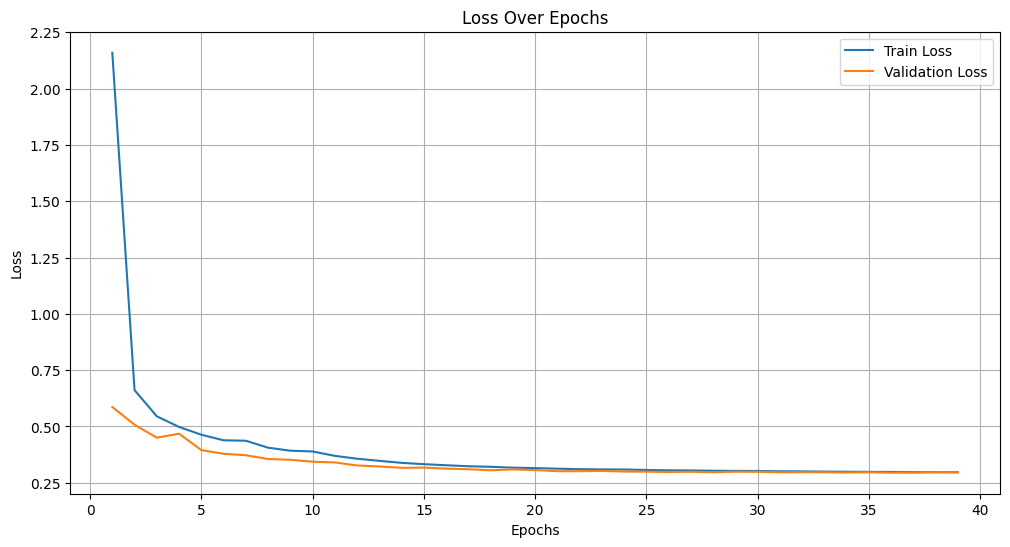

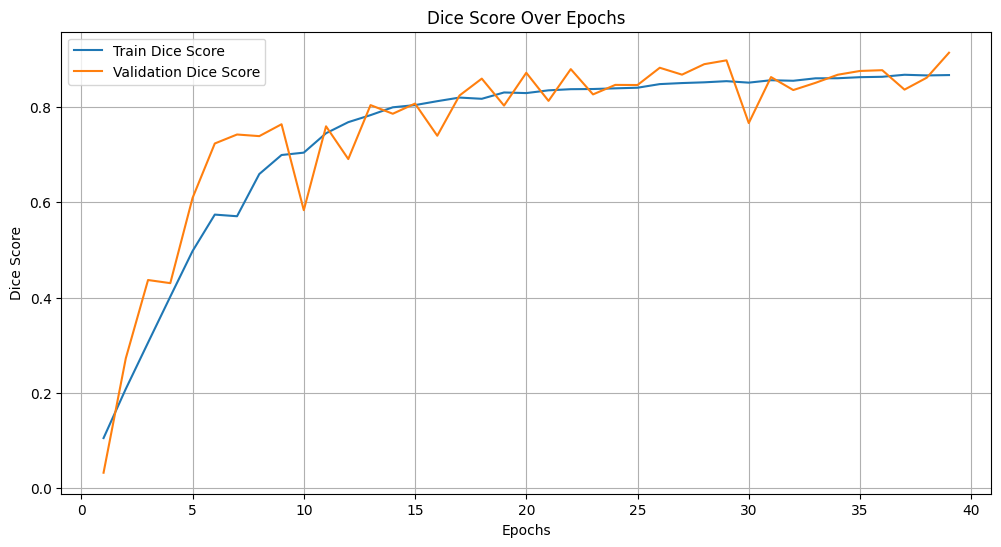

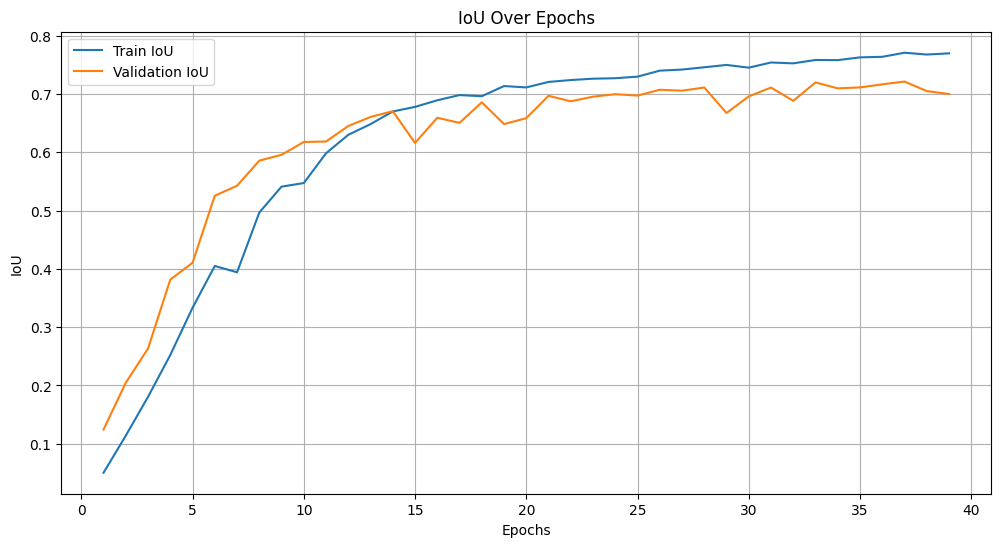

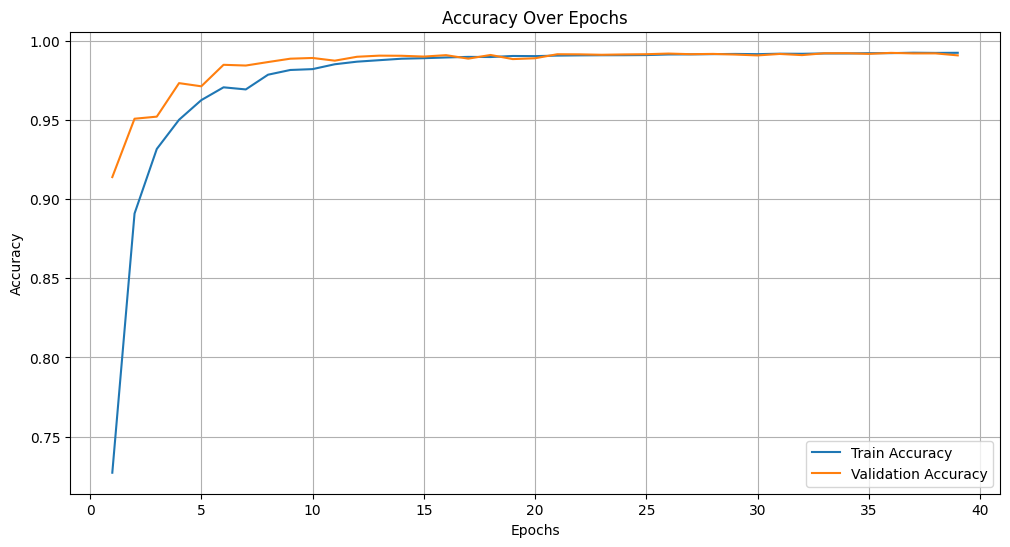

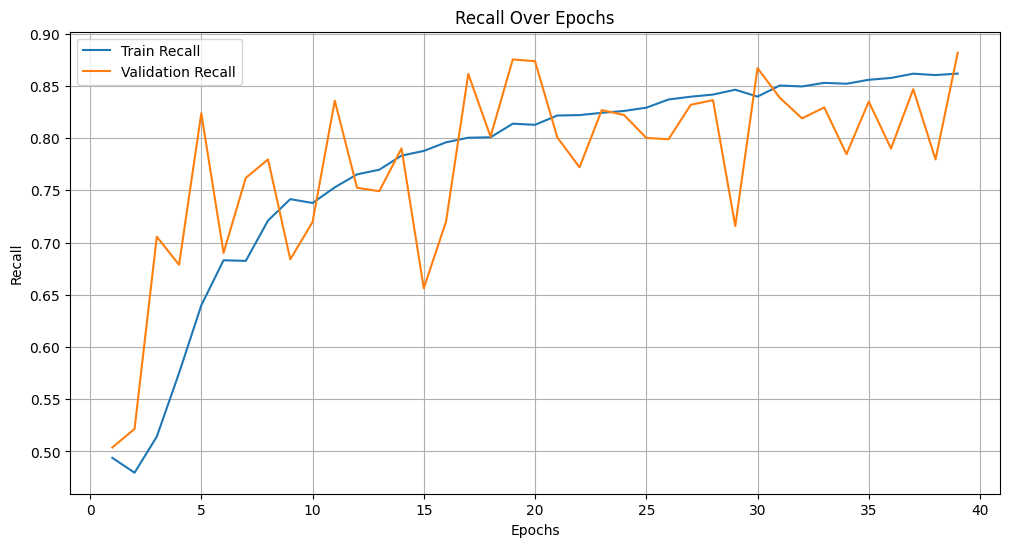

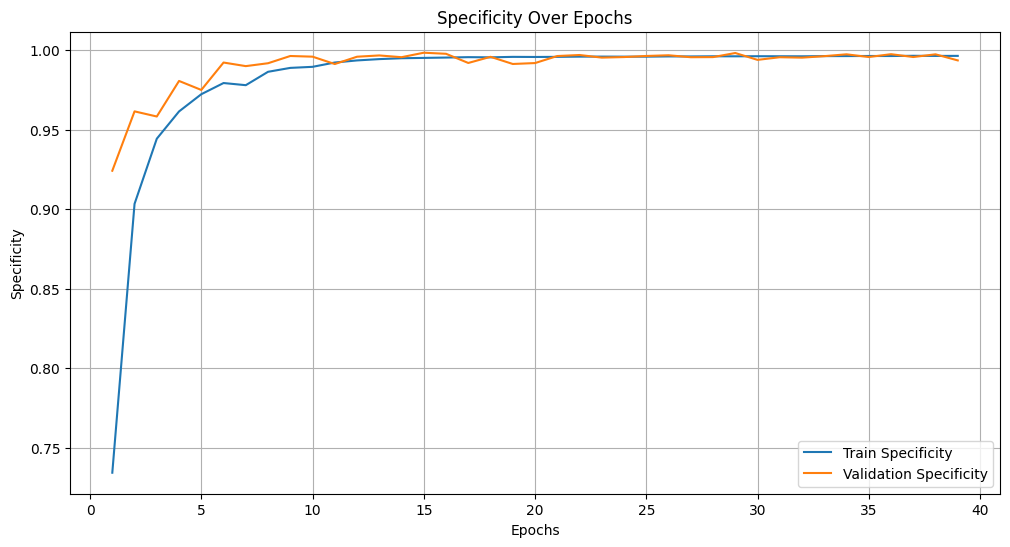

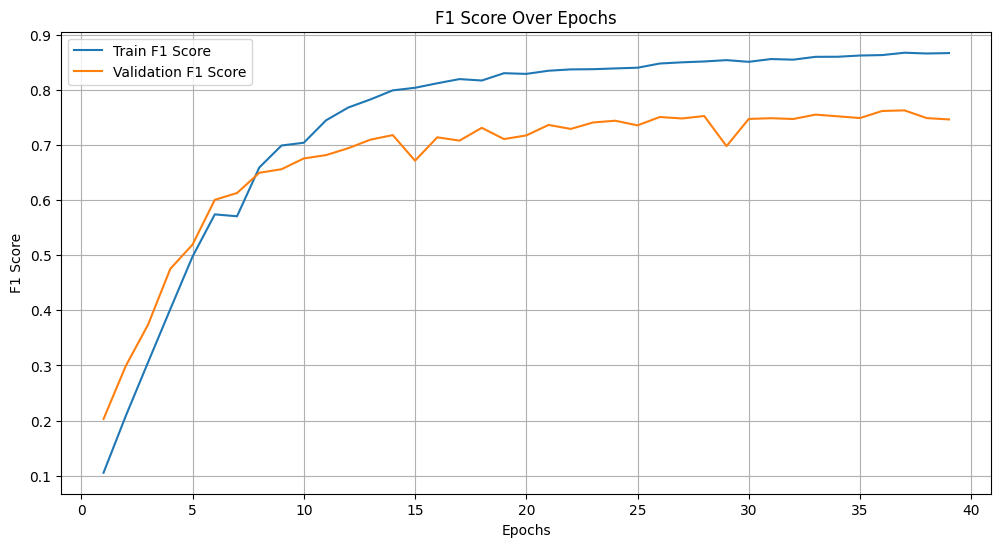

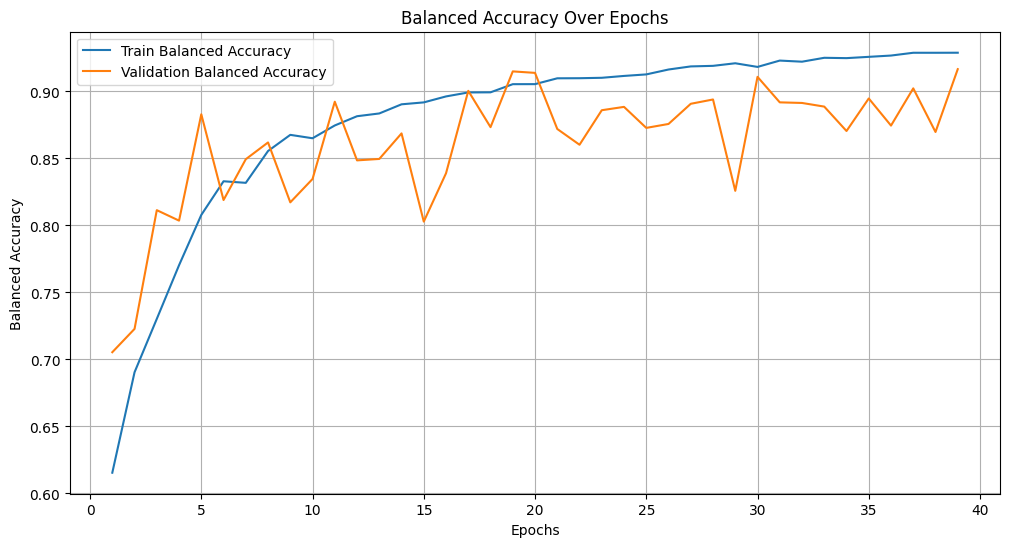

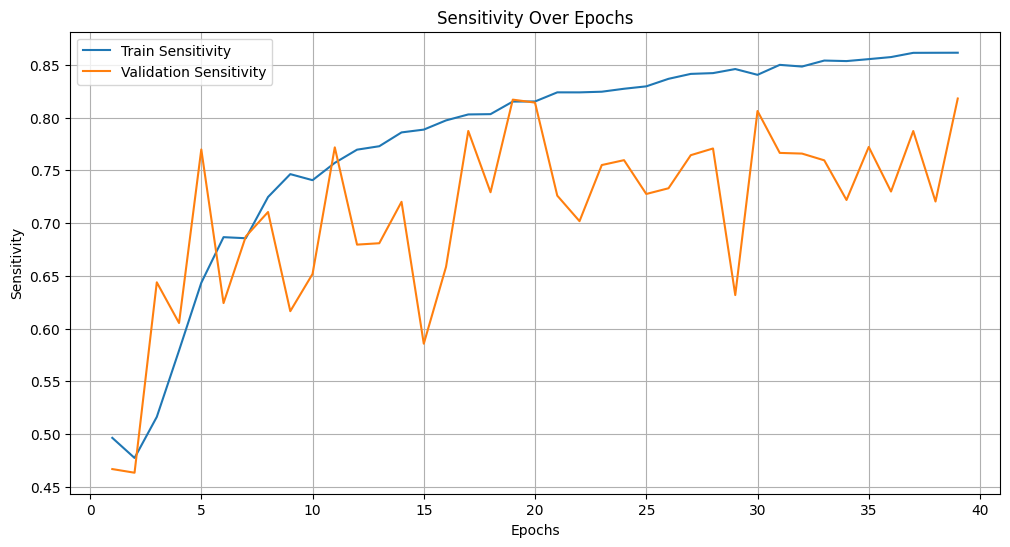

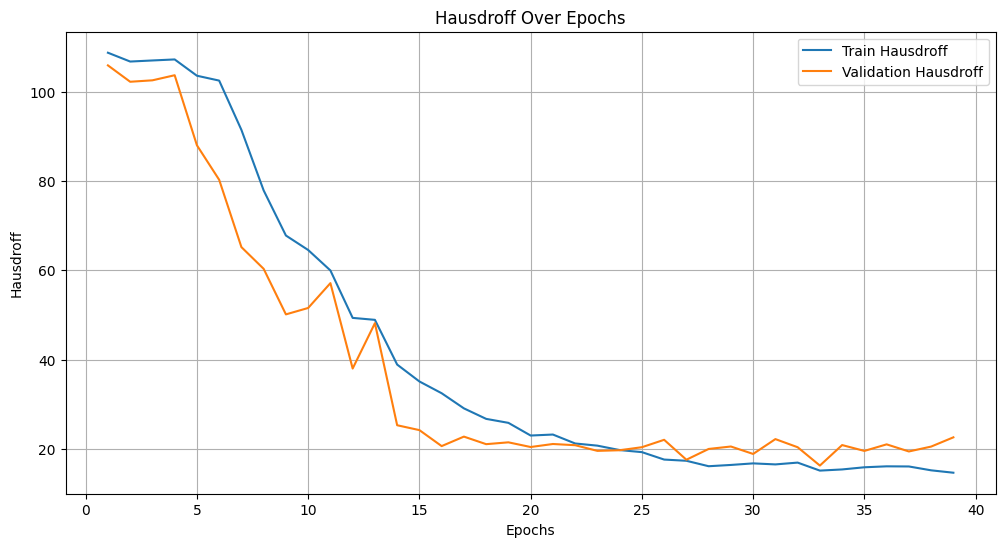

In [36]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_history):
    epochs = range(1, len(metrics_history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics_history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Dice Score
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_dice'], label='Train Dice Score')
    plt.plot(epochs, metrics_history['val_dice'], label='Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Dice Score Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot IoU
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_iou'], label='Train IoU')
    plt.plot(epochs, metrics_history['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics_history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Recall
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics_history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Specificity
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_specificity'], label='Train Specificity')
    plt.plot(epochs, metrics_history['val_specificity'], label='Validation Specificity')
    plt.xlabel('Epochs')
    plt.ylabel('Specificity')
    plt.title('Specificity Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot F1 Score
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_f1'], label='Train F1 Score')
    plt.plot(epochs, metrics_history['val_f1'], label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Balanced Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_bal_acc'], label='Train Balanced Accuracy')
    plt.plot(epochs, metrics_history['val_bal_acc'], label='Validation Balanced Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Balanced Accuracy')
    plt.title('Balanced Accuracy Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_sensitivity'], label='Train Sensitivity')
    plt.plot(epochs, metrics_history['val_sensitivity'], label='Validation Sensitivity')
    plt.xlabel('Epochs')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics_history['train_hausdorff'], label='Train Hausdroff')
    plt.plot(epochs, metrics_history['val_hausdorff'], label='Validation Hausdroff')
    plt.xlabel('Epochs')
    plt.ylabel('Hausdroff')
    plt.title('Hausdroff Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot metrics
plot_metrics(metrics_history)


In [37]:
SAVE_DIR = "./test_predictions"
os.makedirs(SAVE_DIR, exist_ok=True)

In [38]:
# Evaluate the model
test_dataset = NiftiDataset(test_ids, TRAIN_DATASET_PATH)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
import torch
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import JaccardIndex, Accuracy, Recall, Specificity
from sklearn.metrics import balanced_accuracy_score
from skimage.metrics import hausdorff_distance

def test_model_with_saving(test_dataloader, model, criterion_unet, criterion_diffusion, device, save_dir):
    model.eval()

    test_loss = 0.0
    test_dice_score = 0.0
    test_iou_metric = JaccardIndex(task='binary').to(device)
    test_accuracy_metric = Accuracy(task='binary').to(device)
    test_sensitivity_metric = Recall(task='binary').to(device)
    test_specificity_metric = Specificity(task='binary').to(device)

    test_iou_metric.reset()
    test_accuracy_metric.reset()
    test_sensitivity_metric.reset()
    test_specificity_metric.reset()

    all_preds = []
    all_ground_truths = []
    hausdorff_distances = []

    with torch.no_grad():
        for idx, (test_inputs, test_ground_truth) in enumerate(tqdm(test_dataloader, desc="Testing")):
            test_inputs, test_ground_truth = test_inputs.to(device), test_ground_truth.to(device)

            test_initial_mask = model.unet(test_inputs)
            test_loss_unet = criterion_unet(test_initial_mask, test_ground_truth)

            test_error_map = torch.abs(test_initial_mask - test_ground_truth)
            test_reconstructed_error_map, _,_ = model.vae(test_error_map)
            test_loss_diffusion = criterion_diffusion(test_reconstructed_error_map, test_error_map)

            test_combined_loss = test_loss_unet + 0.5 * test_loss_diffusion
            test_loss += test_combined_loss.item()

            test_preds = (torch.sigmoid(test_initial_mask) >= 0.5).float()
            test_dice_score += Dice(test_preds, test_ground_truth)
            test_iou_metric.update(test_preds, test_ground_truth.int())
            test_accuracy_metric.update(test_preds, test_ground_truth.int())
            test_sensitivity_metric.update(test_preds, test_ground_truth.int())
            test_specificity_metric.update(test_preds, test_ground_truth.int())

            all_preds.extend(test_preds.cpu().numpy().flatten())
            all_ground_truths.extend(test_ground_truth.cpu().numpy().flatten())

            if test_preds.sum() == 0 or test_ground_truth.sum() == 0:
                hausdorff_distances.append(0)
            else:
                hausdorff_distances.append(hausdorff_distance(test_preds.cpu().numpy().astype(bool), test_ground_truth.cpu().numpy().astype(bool)))

            if idx < 5:
                for i in range(test_inputs.size(0)):
                    image = test_inputs[i].cpu().squeeze(0).numpy()
                    ground_truth = test_ground_truth[i].cpu().squeeze(0).numpy()
                    prediction = test_preds[i].cpu().squeeze(0).numpy()

                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                    axes[0].imshow(image, cmap='gray')
                    axes[0].set_title("Original Image")
                    axes[0].axis('off')

                    axes[1].imshow(ground_truth, cmap='gray')
                    axes[1].set_title("Ground Truth")
                    axes[1].axis('off')

                    axes[2].imshow(prediction, cmap='gray')
                    axes[2].set_title("Predicted Mask")
                    axes[2].axis('off')

                    save_path = os.path.join(save_dir, f"sample_{idx * test_inputs.size(0) + i}.png")
                    plt.savefig(save_path, bbox_inches='tight')
                    plt.close(fig)

    test_dice_score /= len(test_dataloader)
    test_iou = test_iou_metric.compute()
    test_accuracy = test_accuracy_metric.compute()
    test_sensitivity = test_sensitivity_metric.compute()
    test_specificity = test_specificity_metric.compute()
    test_balanced_accuracy = balanced_accuracy_score(all_ground_truths, all_preds)
    avg_hausdorff = sum(hausdorff_distances) / len(hausdorff_distances)

    print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, "
          f"Dice: {test_dice_score:.4f}, IoU: {test_iou:.4f}, "
          f"Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, "
          f"Accuracy: {test_accuracy:.4f}, "
          f"Balanced Accuracy: {test_balanced_accuracy:.4f}, "
          f"Hausdorff Distance: {avg_hausdorff:.4f}")

    return {
        "Test Loss": test_loss / len(test_dataloader),
        "Dice": test_dice_score,
        "IoU": test_iou,
        "Accuracy": test_accuracy,
        "Sensitivity": test_sensitivity,
        "Specificity": test_specificity,
        "Balanced Accuracy": test_balanced_accuracy,
        "Hausdorff Distance": avg_hausdorff
    }


In [43]:
import os
import torch
from torch.utils.data import DataLoader

# Example setup (replace these with your actual setup)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = './test_results'  # Directory to save predictions
os.makedirs(save_dir, exist_ok=True)

# Assuming `test_dataset` is your test dataset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example loss functions (replace if necessary)
criterion_unet = torch.nn.BCEWithLogitsLoss()
criterion_diffusion = torch.nn.MSELoss()

# Call the function
test_metrics = test_model_with_saving(test_dataloader, model, criterion_unet, criterion_diffusion, device, save_dir)

# Print the metrics
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Testing: 100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Test Loss: 0.2952, Dice: 0.7786, IoU: 0.7344, Sensitivity: 0.7954, Specificity: 0.9977, Accuracy: 0.9924, Balanced Accuracy: 0.8966, Hausdorff Distance: 19.8828

Test Metrics:
Test Loss: 0.2952
Dice: 0.7786
IoU: 0.7344
Accuracy: 0.9924
Sensitivity: 0.7954
Specificity: 0.9977
Balanced Accuracy: 0.8966
Hausdorff Distance: 19.8828


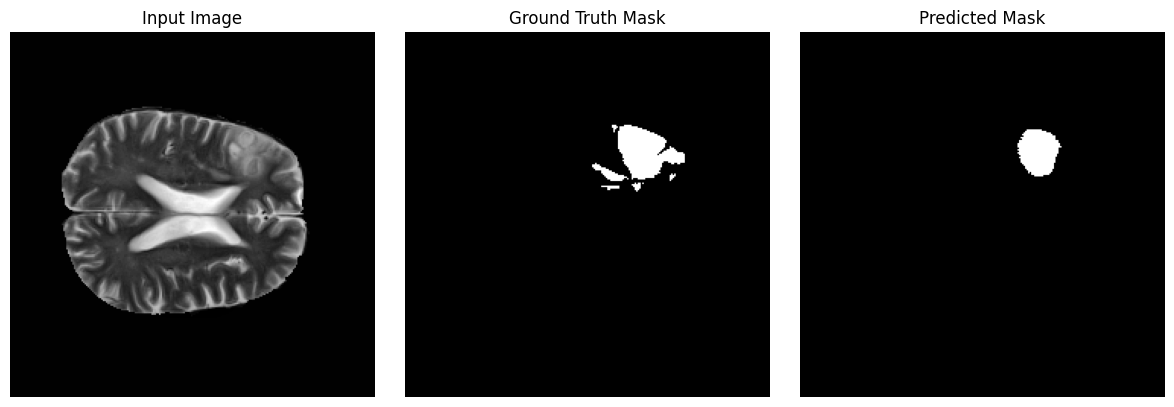

In [44]:
import random
import matplotlib.pyplot as plt
import numpy as np

def visualize_random_prediction(test_dataloader, model, device):
    model.eval()
    
    # Load all test data into a list for random access
    test_data = list(test_dataloader)
    random_batch_idx = random.randint(0, len(test_data) - 1)  # Random batch index
    inputs, ground_truth = test_data[random_batch_idx]
    
    # Choose a random sample from the selected batch
    random_sample_idx = random.randint(0, inputs.size(0) - 1)
    inputs = inputs[random_sample_idx].unsqueeze(0).to(device)
    ground_truth = ground_truth[random_sample_idx].unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        preds = model.unet(inputs)
        preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
        preds_binary = (preds >= 0.5).float()  # Binarize predictions

    # Convert tensors to numpy arrays for visualization
    inputs_np = inputs[0, 0].cpu().numpy()
    ground_truth_np = ground_truth[0, 0].cpu().numpy()
    preds_np = preds_binary[0, 0].cpu().numpy()

    # Plot the input image, ground truth, and prediction
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(inputs_np, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_np, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_np, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a random prediction
visualize_random_prediction(test_dataloader, model, device)


In [45]:
import shutil

# Define the directory to be zipped and the output zip file name
source_dir = '/kaggle/working/test_results'
output_zip = '/kaggle/working/test_predictionsA.zip'

# Create a ZIP file from the directory
shutil.make_archive('/kaggle/working/test_predictions_NEW', 'zip', source_dir)

print(f"Directory '{source_dir}' has been zipped as '{output_zip}'")


Directory '/kaggle/working/test_results' has been zipped as '/kaggle/working/test_predictionsA.zip'


In [46]:
import shutil

# Compress the entire "checkpoints" folder
shutil.make_archive("/kaggle/working/checkpoints_backup", 'zip', "/kaggle/working/checkpoints")

'/kaggle/working/checkpoints_backup.zip'

In [49]:
import os

checkpoint_dir = "/kaggle/working/checkpoints"
print(os.listdir(checkpoint_dir))


['checkpoint_epoch_.pth']


In [51]:
import torch
import os

# Define correct checkpoint path
checkpoint_path = "/kaggle/working/checkpoints/checkpoint_epoch_.pth"

# Check if file exists
if os.path.exists(checkpoint_path):
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Extract and save model state dict
    model_state_dict = checkpoint['model_state_dict']
    torch.save(model_state_dict, "/kaggle/working/model.pth")

    print("Model state dict saved as model.pth!")
else:
    print(f"Checkpoint file not found at {checkpoint_path}")


Model state dict saved as model.pth!


In [53]:
import torch
import os

# Define correct checkpoint path
checkpoint_path = "/kaggle/working/checkpoints/checkpoint_epoch_.pth"

# Check if file exists
if os.path.exists(checkpoint_path):
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Save model state dict
    torch.save(checkpoint['model_state_dict'], "/kaggle/working/model.pth")

    # Save optimizer state dict
    torch.save(checkpoint['optimizer_state_dict'], "/kaggle/working/optimizer.pth")

    # Save epoch as a text file
    with open("/kaggle/working/checkpoints/epoch.txt", "w") as f:
        f.write(str(checkpoint['epoch']))

    print("Model, optimizer, and epoch saved successfully!")
else:
    print(f"Checkpoint file not found at {checkpoint_path}")


Model, optimizer, and epoch saved successfully!
